In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import torch

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

## Dataset loading

In [3]:
dataset_path='dataset'

train_end=100
validation_end=150

In [4]:
files=os.listdir(dataset_path)

X_train=[]
y_train=[]
for i in range(train_end):
    with open(dataset_path+'/'+files[i]) as f:
        phrases = f.read().split('\n\n')
        X_train += [[line.split()[0] for line in p.splitlines()] for p in phrases]
        y_train += [[line.split()[1] for line in p.splitlines()] for p in phrases]

X_val=[]
y_val=[]
for i in range(train_end,validation_end):
    with open(dataset_path+'/'+files[i]) as f:
        phrases = f.read().split('\n\n')
        X_val += [[line.split()[0] for line in p.splitlines()] for p in phrases]
        y_val += [[line.split()[1] for line in p.splitlines()] for p in phrases]

X_test=[]
y_test=[]
for i in range(validation_end,len(files)):
    with open(dataset_path+'/'+files[i]) as f:
        phrases = f.read().split('\n\n')
        X_test += [[line.split()[0] for line in p.splitlines()] for p in phrases]
        y_test += [[line.split()[1] for line in p.splitlines()] for p in phrases]

1963


C:\Users\Sam\AppData\Local\Temp\ipykernel_12620\837564689.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram( X, bins = np.max(X)+1, normed = True )


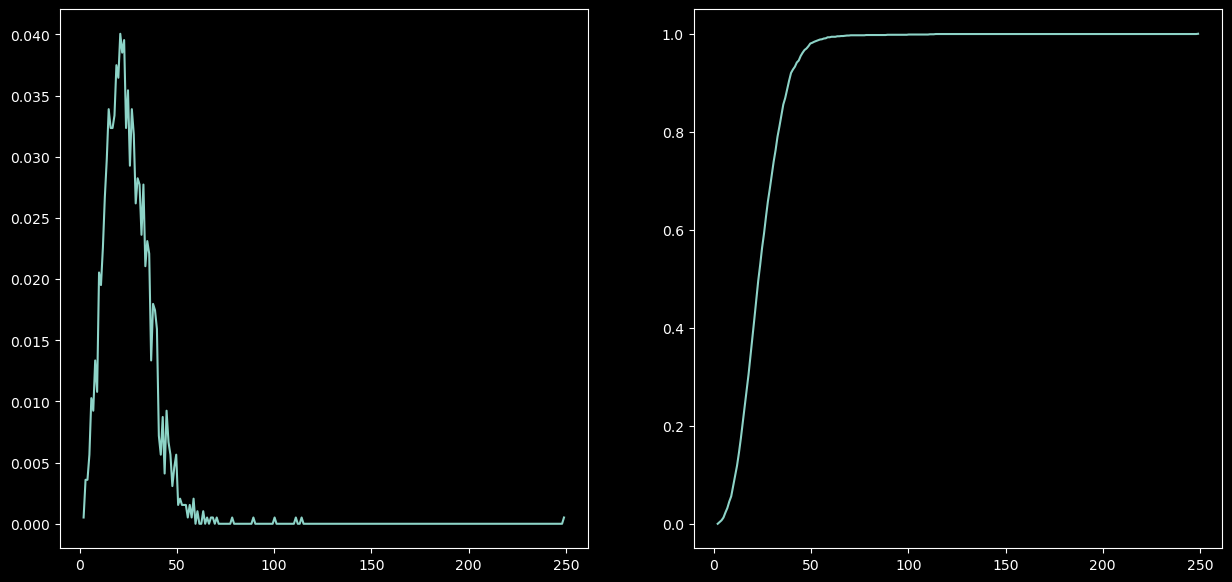

In [5]:
print(len(X_train))
X=[len(phrase) for phrase in X_train]
H,X1 = np.histogram( X, bins = np.max(X)+1, normed = True ) 
C = np.cumsum(H)*(X1[1] - X1[0])

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(X1[1:],H)
plt.subplot(1,2,2)
plt.plot(X1[1:],C)


In [6]:
percentile=0.99

np.where(C>percentile)[0][0]

55

In [8]:
# info

# number of training epochs
n_epochs = 4000

# tolerance
eps = 0.001

# number of sentences to consider
n_sents = 10

# weight embedding size
embedding_size = 50

# learning rate
alpha = 0.1

# AdaGrad parameter 
delta = 0.8

# context_window_size 
window_size = 5

# top N similar words
topN = 5

In [9]:
import re

s="4.1"

pattern = '^[0-9]+.?,?(\\/)?[0-9]*$'

substitution = '[num]'

re.sub(pattern,substitution,s)



'[num]'

In [10]:
X_train=[[re.sub(pattern,substitution,token) for token in phrase] for phrase in X_train]
X_val=[[re.sub(pattern,substitution,token) for token in phrase] for phrase in X_val]
X_test=[[re.sub(pattern,substitution,token) for token in phrase] for phrase in X_test]

In [11]:
import itertools
tokens = list(set(list(itertools.chain(*X_train))))   
n_tokens = len(tokens)
print('Number of Sentences:', len(X_train)) 
print('Number of Tokens:', n_tokens)

Number of Sentences: 1963
Number of Tokens: 7571


In [12]:
'[num]' in tokens

True

In [13]:
from collections import Counter

def get_co_occurences(token, token2int, processed_sents, window_size):
    co_occurences = []
    for sent in processed_sents:
        for idx in (np.array(sent)==token).nonzero()[0]:
            co_occurences.append(sent[max(0, idx-window_size):min(idx+window_size+1, len(sent))])

    co_occurences = list(itertools.chain(*co_occurences))
    co_occurence_idxs = list(map(lambda x: token2int[x], co_occurences))
    co_occurence_dict = Counter(co_occurence_idxs)
    co_occurence_dict = dict(sorted(co_occurence_dict.items()))
    return co_occurence_dict

def get_co_occurence_matrix(co_occurence_matrix, tokens, token2int, processed_sents, window_size):
    for token in tokens:
        token_idx = token2int[token]
        co_occurence_dict = get_co_occurences(token, token2int, processed_sents, window_size)
        co_occurence_matrix[token_idx, list(co_occurence_dict.keys())] = list(co_occurence_dict.values())
        
    np.fill_diagonal(co_occurence_matrix, 0)    
    return co_occurence_matrix

In [14]:
token2int = dict(zip(tokens, range(len(tokens))))
int2token = {v:k for k,v in token2int.items()} 

print('Building co-occurence matrix..')
co_occurence_matrix = np.zeros(shape=(len(tokens), len(tokens)), dtype='int')
co_occurence_matrix = get_co_occurence_matrix(co_occurence_matrix, tokens, token2int, X_train, window_size)
print('Co-occurence matrix shape:', co_occurence_matrix.shape)
assert co_occurence_matrix.shape == (n_tokens, n_tokens)
# co-occurence matrix is similar
assert np.all(co_occurence_matrix.T == co_occurence_matrix)

Building co-occurence matrix..
Co-occurence matrix shape: (7571, 7571)


In [51]:
from utils.glove_loader import load_glove

embedding_dimension = 50

GLOVE_embeddings = load_glove(folder_path='glove_pretrained', embedding_dim=embedding_dimension)

In [16]:
knownIndices = np.array([token2int[key] if key in token2int.keys() else -1 for key in GLOVE_embeddings.keys()])
len(knownIndices[knownIndices!=-1])

5278

In [17]:
knownEmbeddings=np.array([GLOVE_embeddings[int2token[k]] for k in knownIndices[knownIndices!=-1]], dtype=np.float32)
print(len(knownEmbeddings))
print(len(knownEmbeddings[0]))

5278
50


In [28]:
weights = torch.randn(( n_tokens, embedding_size), requires_grad=True, device='cuda')
bias = torch.randn(( n_tokens,), requires_grad=True, device='cuda')
weights_t = torch.randn(( n_tokens, embedding_size), requires_grad=True, device='cuda')
bias_t = torch.randn(( n_tokens,), requires_grad=True, device='cuda')

co_occurence_matrix=torch.tensor(co_occurence_matrix)

mask=torch.ones(( n_tokens, embedding_size))
k_embedding=torch.zeros(( n_tokens, embedding_size))

mask[knownIndices[knownIndices!=-1]]=0
k_embedding[knownIndices[knownIndices!=-1]]=torch.tensor(knownEmbeddings)

mask=mask.to('cuda')
k_embedding=k_embedding.to('cuda')
co_occurence_matrix=co_occurence_matrix.to('cuda')

with torch.no_grad():
    if knownIndices is not None:
        weights= weights*mask + k_embedding

optimizer=torch.optim.Adam([weights,bias], lr=1)

C:\Users\Sam\AppData\Local\Temp\ipykernel_12620\951819838.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  co_occurence_matrix=torch.tensor(co_occurence_matrix)


In [29]:
def f(x, alpha=3/4, xmax = 100):
    return torch.clip(torch.pow(x/xmax, alpha),0,1)

def loss_function(weights, weights_t, bias, bias_t, co_occurence_matrix, f):   # TODO reorder function
    
    l1 = weights @ weights_t.T
    l2 = bias + bias_t[:,None]
    l3=torch.log(1 + co_occurence_matrix)
    l = l1 + l2 - l3
    l  =torch.square(l)
    lf = f(co_occurence_matrix)
    l = lf*l
    l = torch.sum(l)
    return l


In [30]:
L=[]
for epoch in range(100):  # loop over the dataset multiple times
 
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = loss_function(weights, weights_t, bias, bias_t, co_occurence_matrix, f)
    loss.backward()
    optimizer.step()
    
    if knownIndices is not None:
        with torch.no_grad():
            weights = weights*mask + k_embedding
    
    L.append(loss.detach().cpu().numpy())
    if epoch%10==9:
        print('epochs:',epoch+1,'loss:',loss.detach().cpu().numpy())
        

print('Finished computing glove embeddings')

epochs: 10 loss: 227247.47
epochs: 20 loss: 221310.77
epochs: 30 loss: 218091.66
epochs: 40 loss: 216974.88
epochs: 50 loss: 216620.5
epochs: 60 loss: 216464.84
epochs: 70 loss: 216412.23
epochs: 80 loss: 216391.6
epochs: 90 loss: 216384.12
epochs: 100 loss: 216381.81
Finished computing glove embeddings


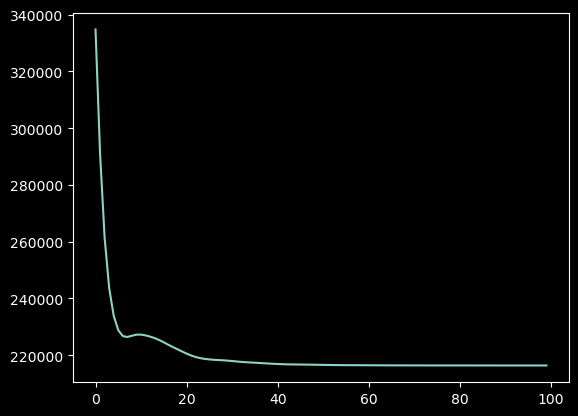

In [31]:
plt.plot(L)

In [33]:
print(len(tokens))
print(weights.shape)

7571
torch.Size([7571, 50])


In [55]:
EMBEDING_train = { tokens[i]:weights[i].cpu().numpy() for i in range(len(tokens)) }
EMBEDING_train.update(GLOVE_embeddings)
print(len(EMBEDING_train.keys()))

402293
